In [1]:
import astropy.units as u
import numpy as np
import popsims
import matplotlib.pyplot as plt
import astropy.coordinates as astro_coord
import glob
import pandas as pd

import itertools
from scipy import stats

from popsims.plot_style import  plot_style
plot_style()

#from shapey import Box
#paths
path_plot ='../figures/'
path_data = '../data/stream/'
isochrone_path='../data/isochrones/'
path_pipeline= '../data/pipeline/'

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from scipy.interpolate import UnivariateSpline

In [2]:
#SOME CONSTANTS

dgrid=np.arange(0.5, 10, 0.2)
BEST_BW=0.7
#dgrid
THEORITICAL_STREAM_WIDTHS={'10_20': 0.053, '30_40': 0.094, '50_60':1.53}
GAP_SIZES={'10_20': 1.4, '30_40': 2.5, '50_60': 1.8}

In [3]:
#functions
def show_gap_detection(vld,  GAP_SIZE, plot='None', ax=None, alpha=0.1, ms=0.1):
        #define stuff 
        meshgrid= vld['meshgrid']
        data=vld['data']
        
        grid_data = np.hstack([ xi.ravel().reshape(-1,1) for xi in meshgrid])
        
        gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'].flatten(),90 ) 
        stream_mask= vld['min_eigen'] < np.percentile(vld['min_eigen'].flatten(),15)
        
        #define weights as the density inside the stream
        #weights= 
        
        if np.isnan( vld['min_eigen']).all():
            return {}
        
        stream_size=1.0*np.nanstd(meshgrid[1][stream_mask])

        pol=np.poly1d(np.polyfit(meshgrid[0][stream_mask], meshgrid[1][stream_mask], 2))
        #pol=UnivariateSpline(meshgrid[0][stream_mask], meshgrid[1][stream_mask])


        #define stream track and gap track
        stream_track=np.abs(grid_data[:,1] - pol(grid_data[:,0]))< stream_size/2
        #redefine the stream track as a check (just a random place at 0.5 pc from the center)

        gap_center=(np.nanmedian(meshgrid[0][gap_mask]), np.nanmedian(meshgrid[1][gap_mask]))

        gap_track=np.logical_and.reduce([np.abs((grid_data[:,0]-gap_center[0])) <GAP_SIZE/2,
                                        stream_track])
        #gap_track= np.abs((grid_data[:,0]-gap_center[0])) <GAP_SIZE/2

        #print (data[0])
        
        data_df=pd.DataFrame()
        data_df['x']=data[0]
        data_df['y']=data[1]
        
        grid_df=pd.DataFrame()
        grid_df['x']= grid_data[:,0]
        grid_df['y']= grid_data[:,1]
        
        stream_track_on_data=(np.abs(pol( data_df.x)-data_df.y)<stream_size/2).values
        gap_track_on_data=np.logical_and(np.abs((data_df.x-gap_center[0])) <GAP_SIZE/2,  stream_track_on_data)

        nstars_stream=len( data_df[stream_track_on_data])
        nstars_bck=len( data_df[~stream_track_on_data])
        nstars_gap=len( data_df[gap_track_on_data])

        #verify
        stream_area=10*len( grid_df[stream_track])/len(grid_df)
        bck_area=10*len( grid_df[~stream_track])/len(grid_df)
        gap_area=10*len(grid_df[gap_track])/len(grid_df)
        
         #compute relevant statistics
        gap_offset=5
        try:
            gap_offset=np.nanmedian(np.abs(meshgrid[0][gap_mask]-np.nanmedian(meshgrid[0])))
        except:
            pass
        
        stats={'spread_stream_stars_x': np.nanstd(meshgrid[0][stream_mask]),
               'spread_stream_stars_y': np.nanstd(meshgrid[1][stream_mask]),
              'spread_gap_stars_x': np.nanstd(meshgrid[0][gap_mask]),
            'spread_gap_stars_y':np.nanstd(meshgrid[1][gap_mask]),
               'nstars_gap':  nstars_gap,
               'nstars_stream':  nstars_stream,
               'nstars_bck': nstars_bck,
               'stream_area': stream_area,
               'gap_area': gap_area,
               'bck_area': bck_area,
               'stream_dens':  np.divide(nstars_stream, stream_area),
               'gap_dens': np.divide(nstars_gap, gap_area),
               'bck_dens':np.divide(nstars_bck, bck_area),
               'offset_center':gap_offset,
               'gap_center': np.nanmedian(grid_data[:,0][gap_track]),
               'gap_points':grid_data[:,0][gap_track],
               'stream_center': np.nanmedian(grid_data[:,1][stream_track]),
               'stream_points':grid_data[:,1][stream_track],
               'stream_stars':data[1][stream_track_on_data],
               'gap_stars':data[0][gap_track_on_data],
              }

        if plot=='show_mask_data':
            ax.scatter(data_df.x, data_df.y,  s=ms, alpha=alpha, c='k')
            ax.scatter(data_df.x[stream_track_on_data], data_df.y[stream_track_on_data],  s=10, alpha=0.1, c='r', label='Stream')
            ax.scatter(data_df.x[gap_track_on_data], data_df.y[gap_track_on_data],  s=10, alpha=0.1, c='b', label='Gap')
        
        if plot=='show_mask_grid':
            ax.scatter(grid_df.x, grid_df.y,  s=ms, alpha=alpha, c='k')
            ax.scatter(grid_df.x[stream_track], grid_df.y[stream_track],  s=10, alpha=1, c='r', label='Stream')
            ax.scatter(grid_df.x[gap_track], grid_df.y[gap_track],  s=10, alpha=1, c='b', label='Gap')
            #ax.scatter(grid_df.x[stream_track], grid_df.y,  s=10, alpha=0.1, c='b', label='Bckgd')
            
        if plot=='show_gap_points':
            #ax.scatter(grid_df.x, grid_df.y,  s=ms, alpha=alpha, c='k')
            #ax.scatter(grid_df.x[stream_track], grid_df.y[stream_track],  s=10, alpha=1, c='r', label='Stream')
            ax.scatter(grid_data[:,0][gap_track],grid_data[:,1][gap_track],  s=ms, alpha=alpha, c='#01FF70', marker='*')
            #ax.scatter(grid_df.x[stream_track], grid_df.y,  s=10, alpha=0.1, c='b', label='Bckgd')
        
        if plot=='plot0':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1],s=10, alpha=alpha, c='k')
            
        if plot=='plot1':

            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=1)
            #ax.scatter(grid_data[:,0], grid_data[:,1], c=res['max_eigen'].flatten(),
            #           s=1, cmap='cubehelix')

        if plot=='plot2':

            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['min_eigen'],  20, \
                              cmap='cubehelix', alpha=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            
        if plot=='plot6':
            #ax.scatter(vld['data'][:,0], vld['data'][:,1],s=0.1, alpha=0.5, c='k')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=alpha, vmin=0, vmax=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                            cmap='Greys', alpha=.1, vmin=0.0, vmax=0.2, linestyle='--')
            
            
            
        if plot=='plot4':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1],s=ms, alpha=alpha,  c='#FFFFFF')
            ax.scatter(meshgrid[0][stream_mask], meshgrid[1][stream_mask], marker='*', s=15,c='#FF851B')
            ax.scatter(meshgrid[0][gap_mask], meshgrid[1][gap_mask], marker='*', s=15,  c='#0074D9')
            
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#FF851B', linewidth=3)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])

        if plot=='plot3':
            #verify by plotting
            #ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=alpha, c='k')
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
        if plot=='plot7':
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')
            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

            #plot gap track
            ax.scatter(np.nanmedian(grid_data[:,0][gap_track]), \
                       np.nanmax(vld['meshgrid'][1])-0.5, color='k', marker='$\u2193$', s=100)
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
            
            
        if plot=='plot5':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=0.2, c='k')
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, cmap='magma_r', alpha=0.5)

            #plot stream track
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#0074D9', linewidth=3)
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#0074D9', linewidth=3)

            #plot gap track
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
            
        if plot=='density':
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')
            p= ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')

       
        return stats


In [4]:
def get_pipeline_results_full(dmod, mag_limit, rgc, bwu=BEST_BW):
    fls=glob.glob('../data/pipeline/pipeline_rgc{}_mhalo5.00e+06_maglimit{:.2f}_run*.npy'.format(rgc, mag_limit))
    #print (fls
    res=[]
    for f in fls:
        c=np.load(f, allow_pickle=True)
        for vls in c:
            for k in vls.keys():
                bw=(k.split('dmod_galaxy')[0]).split('bw')[-1]
                dmodx=float(k.split('dmod_galaxy')[-1])
                #print (bw)
                if (dmod ==dmodx) and (float(bw)==bwu):
                    res.append(vls[k])
                else:
                    continue
    return res

In [5]:
df = pd.DataFrame()
for f in tqdm(glob.glob('../data/pipeline/*.npy')):
    vlsx=np.load(f, allow_pickle=True)
    for vls in vlsx:
        for k in vls.keys():
            #for i in range(0, 10):
            rgc=f.split('rgc')[-1].split('_mhalo')[0]
            r=pd.Series(show_gap_detection(vls[k],  GAP_SIZES[rgc]))#, ax=ax, plot='plot3'))

            r['rgc']=rgc
            r['run']=f.split('_')[-1].split('.npy')[0]
            r['mag_limit']=float(f.split('_')[-2].split('maglimit')[1])
            r['bw']=float((k.split('dmod_galaxy')[0]).split('bw')[-1])
            r['dmod']=float(k.split('dmod_galaxy')[-1])
            #r['trial']=i


            df=df.append(r, ignore_index=True )

100%|████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


In [6]:
bws=np.unique(df.bw)



In [7]:
np.unique(df.dmod)

array([24.52, 25.  , 25.88, 28.49])

In [8]:
15/2

7.5

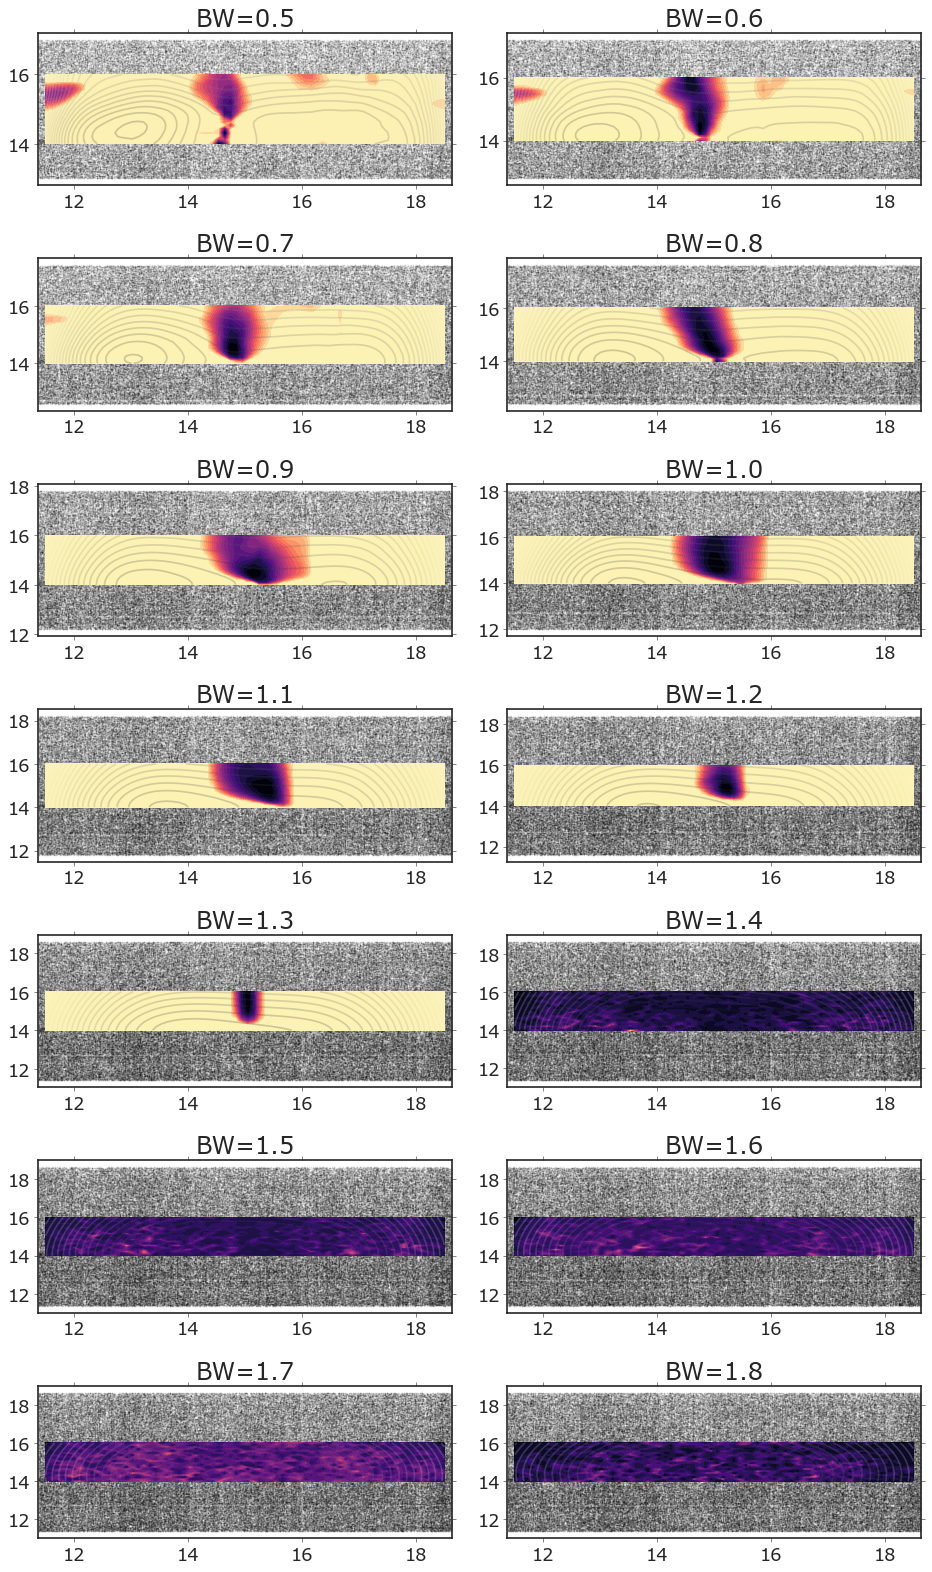

In [16]:
fig, ax=plt.subplots(ncols=2, nrows=7, figsize=(12, 20))
for bw, ax in zip(bws, np.concatenate(ax)):
    res=get_pipeline_results_full(24.52, 28.69, '10_20', bwu=bw)[0]
    dt=res['data']
    ax.scatter(dt[0], dt[1], s=0.1, alpha=0.15, c='k')
    _= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot1', ax=ax, alpha=0.5)
    ax.set(xlim=[dt[0].min(), dt[0].max()])
    #print (dt[1].max())
    ax.set(title='BW={}'.format(bw))
plt.tight_layout()

In [10]:
np.unique(df.dmod)

array([24.52, 25.  , 25.88, 28.49])

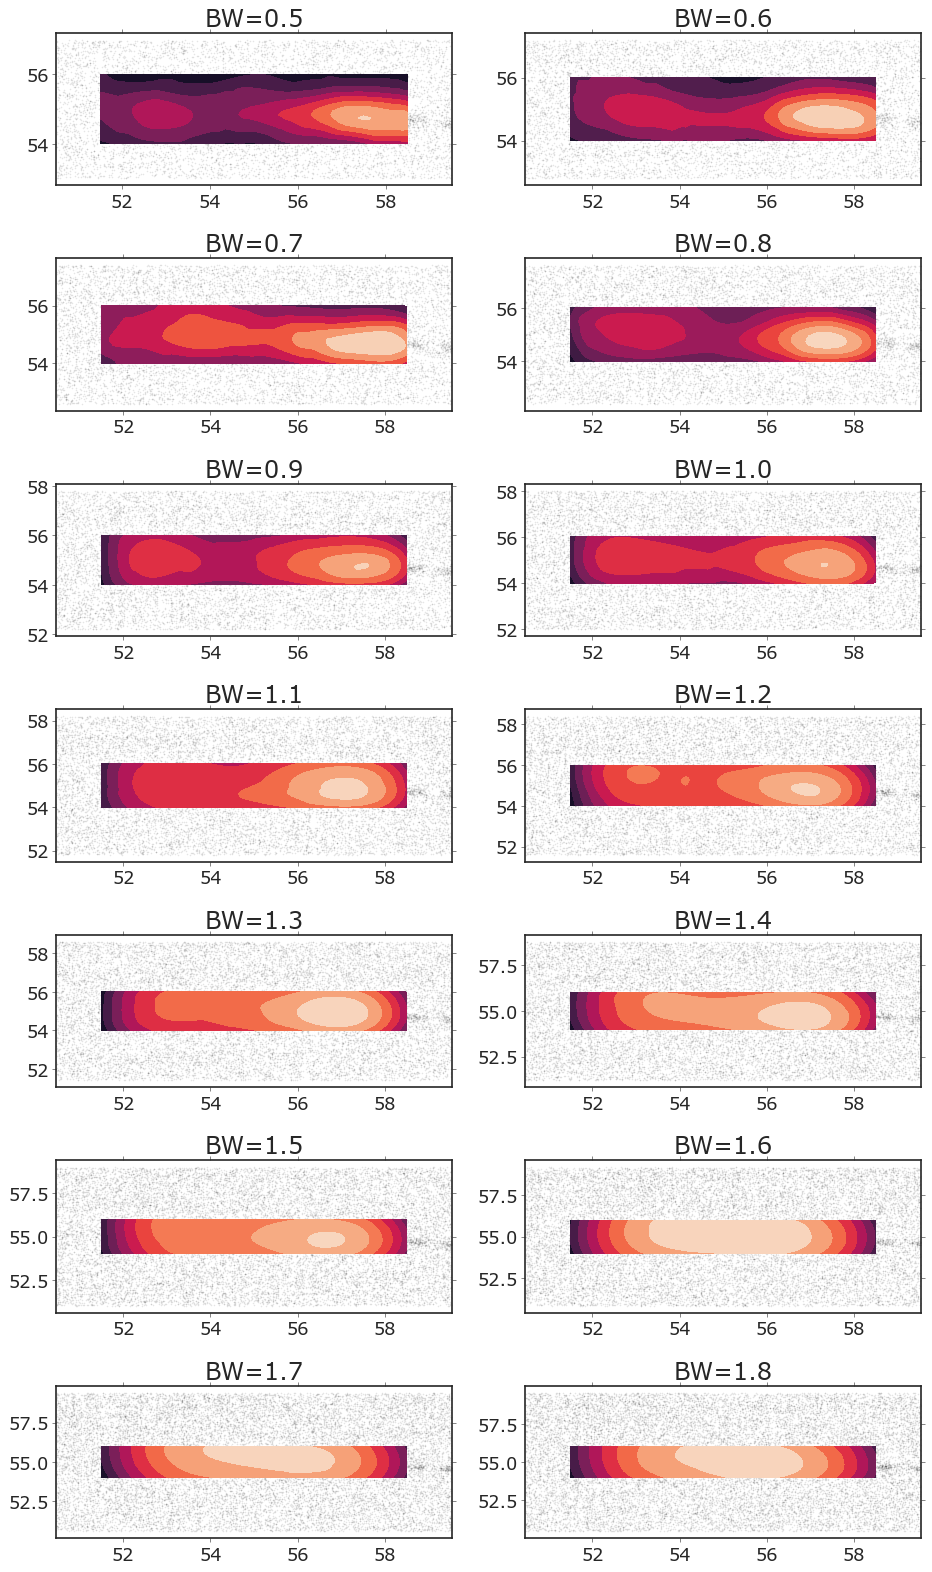

In [21]:
fig, ax=plt.subplots(ncols=2, nrows=7, figsize=(12, 20))
for bw, ax in zip(bws, np.concatenate(ax)):
    res=get_pipeline_results_full(25., 28.69, '50_60', bwu=bw)[0]
    dt=res['data']
    ax.scatter(dt[0], dt[1], s=0.1, alpha=0.15, c='k')
    ax.contourf(res['meshgrid'][0], res['meshgrid'][1], res['density'])
    #_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='density', ax=ax, alpha=0.5)
    ax.set(xlim=[dt[0].min(), dt[0].max()])
    #print (dt[1].max())
    ax.set(title='BW={}'.format(bw))
plt.tight_layout()

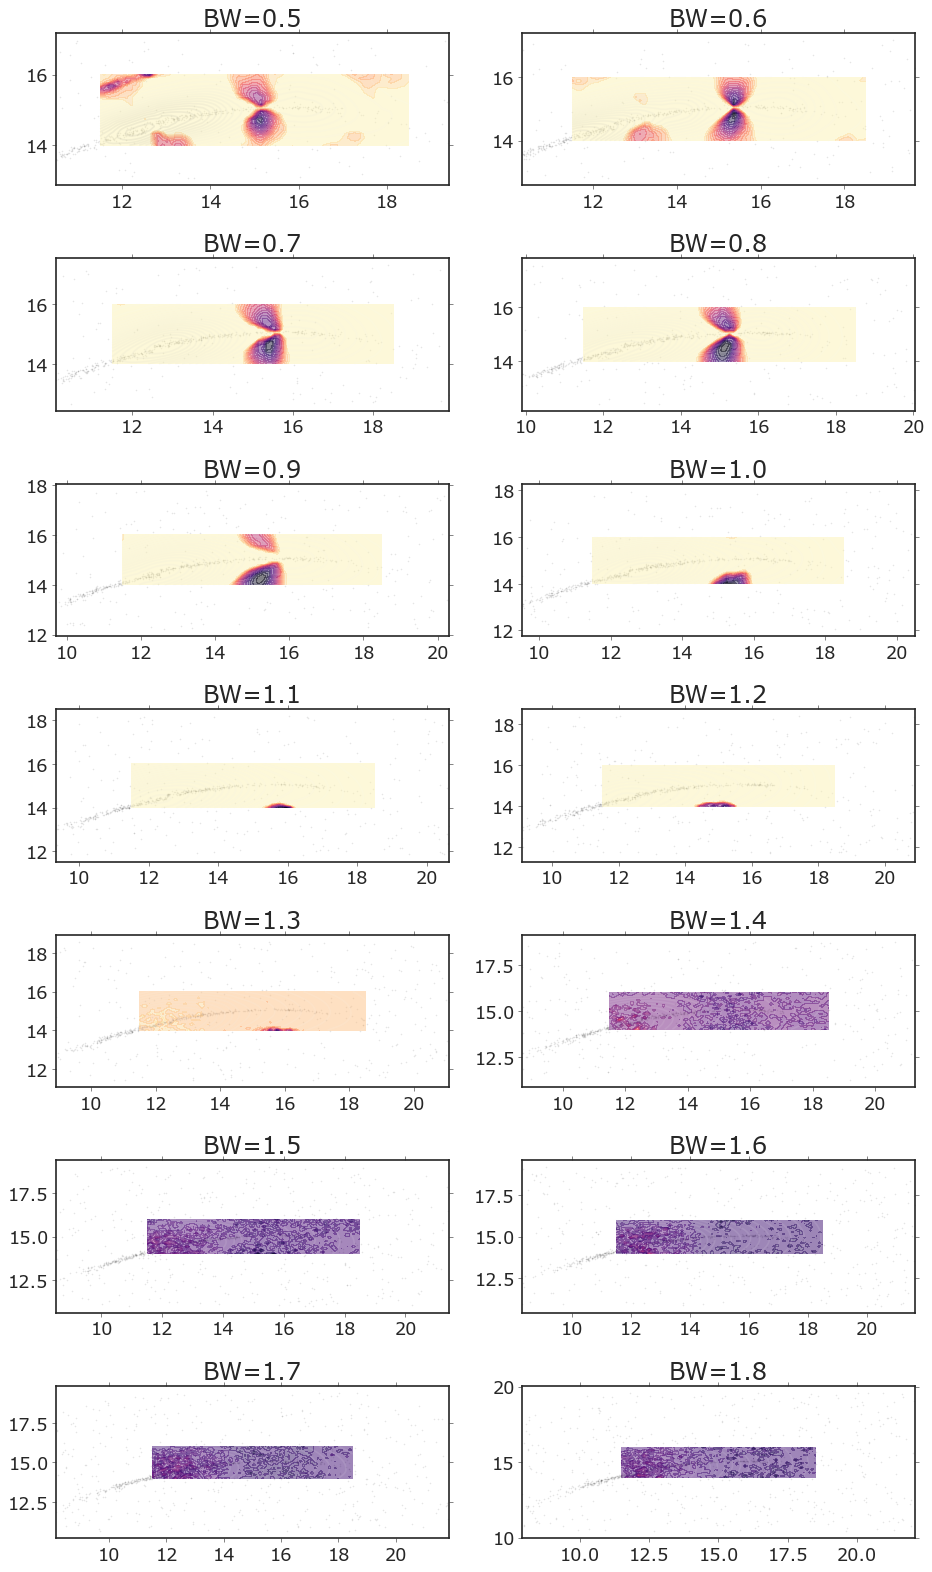

In [12]:
fig, ax=plt.subplots(ncols=2, nrows=7, figsize=(12, 20))
for bw, ax in zip(bws, np.concatenate(ax)):
    res=get_pipeline_results_full(28.49, 28.69, '10_20', bwu=bw)[0]
    dt=res['data']
    ax.scatter(dt[0], dt[1], s=0.1, alpha=0.15, c='k')
    _= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot6', ax=ax, alpha=0.5)
    ax.set(xlim=[dt[0].min(), dt[0].max()])
    #print (dt[1].max())
    ax.set(title='BW={}'.format(bw))
plt.tight_layout()

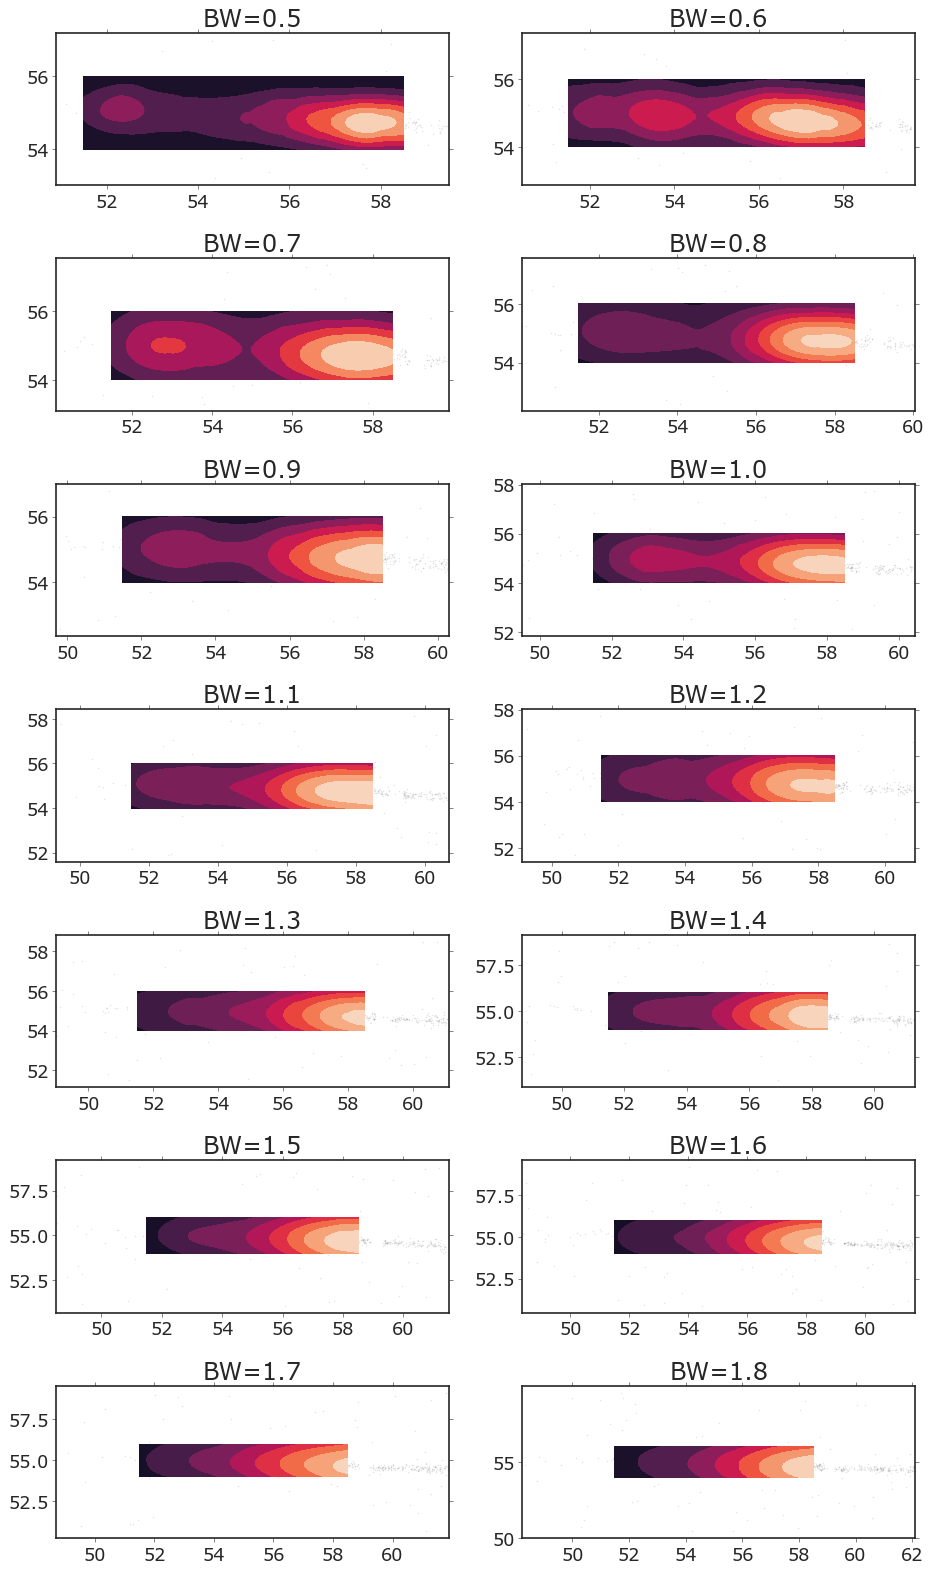

In [23]:
fig, ax=plt.subplots(ncols=2, nrows=7, figsize=(12, 20))
for bw, ax in zip(bws, np.concatenate(ax)):
    res=get_pipeline_results_full(28.49, 28.69, '50_60', bwu=bw)[0]
    dt=res['data']
    ax.scatter(dt[0], dt[1], s=0.1, alpha=0.15, c='k')
    #_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot6', ax=ax, alpha=0.5)
    ax.contourf(res['meshgrid'][0], res['meshgrid'][1], res['density'])
    #_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='density', ax=ax, alpha=0.5)
    ax.set(xlim=[dt[0].min(), dt[0].max()])
    ax.set(xlim=[dt[0].min(), dt[0].max()])
    #print (dt[1].max())
    ax.set(title='BW={}'.format(bw))
plt.tight_layout()